In [19]:
import numpy as np
from scipy.signal import resample_poly, spectrogram
from utils.LoRa import LoRa
import matplotlib.pyplot as plt
from utils.LoRa import MultiBAM

import importlib
import utils.my_lora_utils
importlib.reload(utils.my_lora_utils)
from utils.my_lora_utils import *

In [20]:
sf = 9
bw = 125000
fs = 1000000
lora_init = LoRa(sf, bw)

## HOW TO LOAD WEIGHT
layers = [256*15, 1024, 256] # <-- must match training

multi_bam = MultiBAM(layers_dims=layers, eta=1e-5)
for i, bam in enumerate(multi_bam.bams):
    bam.W = np.load(f"weight_3840_1024_256/weights_layer_{i}.npy")


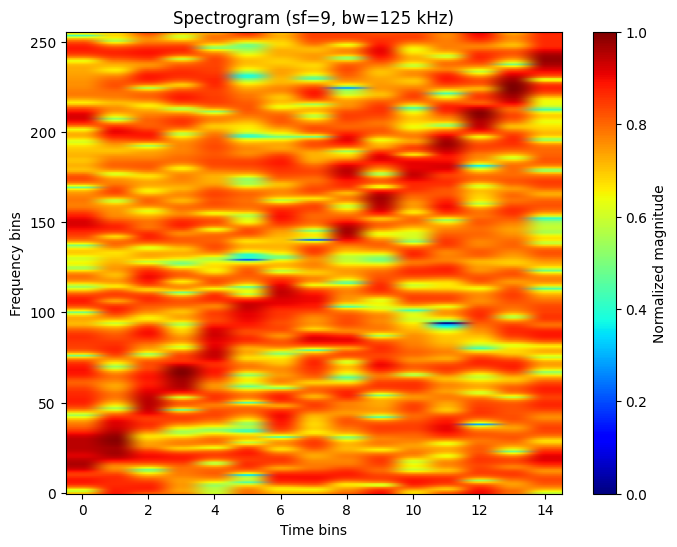

(1, 256)
(1, 1, 3840)
(256, 15)


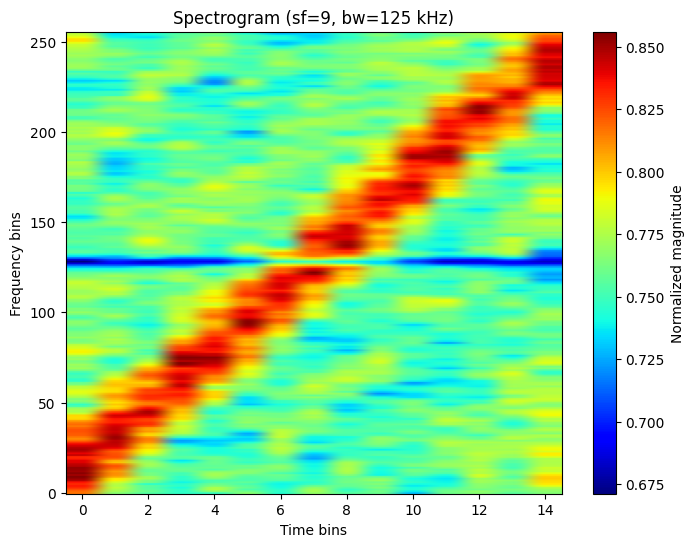

In [22]:
# EXAMPLE OF COMPRESS and DECOMPRESS
x1 = lora_init.gen_symbol_fs(0, sf=sf, bw=bw, Fs=int(bw*8))  # you had Fs=int(bw*8)=1e6
snr = -15
x = lora_init.awgn_iq(x1,snr)

#### STEP 1 PREPROCESS : DOWNSAMPLING ########
x_ds,fs_new = downsampling(x,fs,4)

#### STEP 2 Create Spectrogram ########
aa,bb,cc = create_spectrogram_npy(x_ds,fs_new,0,0,1,None)
show_spectrogram_from_npy(aa)

#### STEP 3 FLATTEN INPUT ########
flat = aa.flatten().reshape(1, -1) # BEFORE COMPRESS MUST 
out1 = multi_bam.compress(flat)
print(out1.shape)
out2 = multi_bam.decompress(out1)
print(out2.shape)

#### STEP 4 AFTER DECOMPRESS RESHAPE to INITIAL SHAPE ########
reco_flat = out2.reshape(-1)  # AFTER DECOMPRESS MUST
reco_spec = reco_flat.reshape(256, 15)
print(reco_spec.shape)

show_spectrogram_from_npy(reco_spec)